In [80]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Marsh Erosion in 2D
dx = 100.
dy = 100.
nx = 7
ny = 8

# center points
xc = np.arange(0,nx)*dx + dx/2. # row vector
yc = np.arange(0,ny).reshape((ny,1))*dy + dy/2. # col vector

# replicate to make 2D arrays
xc = np.tile(xc,(ny,1))
yc = np.tile(yc,(1,nx))
print("Shape of xc",np.shape(xc))
print("Shape of yc",np.shape(yc))

# marsh mask
mmask = np.zeros((ny,nx))
mmask[2][2:5]=1.
mmask[3][2:5]=1.
mmask[4][2:5]=1.
mmask[5][2:5]=1.

# uniform elevations to domain
dz = .5*np.ones_like(mmask)

# ...but make marsh cells taller
dz[mmask>0.]=2.
print(xc)
print(yc)
print(dz)

# arrays for cumulative e-w and n-s erosion
xm = np.zeros_like(mmask)
ym = np.zeros_like(mmask)

Shape of xc (8, 7)
Shape of yc (8, 7)
[[  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]
 [  50.  150.  250.  350.  450.  550.  650.]]
[[  50.   50.   50.   50.   50.   50.   50.]
 [ 150.  150.  150.  150.  150.  150.  150.]
 [ 250.  250.  250.  250.  250.  250.  250.]
 [ 350.  350.  350.  350.  350.  350.  350.]
 [ 450.  450.  450.  450.  450.  450.  450.]
 [ 550.  550.  550.  550.  550.  550.  550.]
 [ 650.  650.  650.  650.  650.  650.  650.]
 [ 750.  750.  750.  750.  750.  750.  750.]]
[[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5  2.   2.   2.   0.5  0.5]
 [ 0.5  0.5 

In [81]:
# scarp height arrays - these are like u, v arrays
zmx = np.zeros((ny,nx+1))
zmy = np.zeros((ny+1,nx))
for iy in range(ny):
    zmx[iy,1:nx]=np.diff(dz[iy,:])
    
for ix in range(nx):
    zmy[1:ny,ix]=np.diff(dz[:,ix])
    
print(zmx)
print(zmy)

[[ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   1.5  0.   0.  -1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.5  1.5  1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.5 -1.5 -1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]]


In [85]:
# Calculate volume and mass
rhos = 2650.
cb = 0.5
V = dx*dy*dz
M = (1.-cb)*rhos*V

tt = 50*24.*3600.       # 50 days
dt = 24.*3600.          # dt = 1 day
nt = int(np.ceil(tt/dt))

# array for tracking total mass
M_a =  np.nan*np.ones((nt))
M_a[0]=np.sum(M)

# Run
for i in range(1):
    
    # calculate scarp heights (retain sign of change)
    for iy in range(ny):
        zmx[iy,1:nx]=np.diff(dz[iy,:])
    
    for ix in range(nx):
        zmy[1:ny,ix]=np.diff(dz[:,ix])
    
    # make uniform arrays of erosion distance magnitude (always shoreward)
    dxm = dt*300./(3600.*24.*365.)*np.ones_like(zmx)
    dym = dt*300./(3600.*24.*365.)*np.ones_like(zmy)
    
    for ix in range(nx):
        for iy in range(ny):
            # only do these operations in a cell masked as marsh
            if(mmask[iy,ix]>0.):
                dxw = dxm[iy,ix]
                dxe = dxm[iy,ix+1]
                dys = dym[iy,ix]
                dyn = dym[iy+1,ix]
                
                # temporary value for cumulative erosion
                xmt = xm[iy,ix]+(dxw+dxe)
                ymt = ym[iy,ix]+(dys+dyn)
                
                # if cumulative erosion is bigger than the e-w cell size, reduce proportionately
                if(xmt>dx):
                    dxe = dx*dxe/(dx-(dxw+dxe+xm[ix,iy]))
                    dxw = dx*dxw/(dx-(dxw+dxe+xm[ix,iy]))

                # if cumulative erosion is bigger than the n-s cell size, reduce proportionately
                if(ymt>dy):
                    dyn = dy*dyn/(dy-(dyn+dys+ym[ix,iy]))
                    dys = dy*dys/(dy-(dyn+dys+ym[ix,iy]))
                    
                # new values for cumulative erosion (should never exceed dx, dy)
                xm[iy,ix] += dxw+dxe
                ym[iy,ix] += dys+dyn
                
                # volumes eroded - this is the average of eroding e-w first and n-s second and vice versa
                # TODO: make erosion zero if marsh is lower than adjacent cell
                vxw = dxw*np.abs(zmx[iy,ix])*0.5*(dy+(dy-(dyn+dys)))
                vxe = dxe*np.abs(zmx[iy,ix+1])*0.5*(dy+(dy-(dyn+dys)))
                vys = dys*np.abs(zmy[iy,ix])*0.5*(dx+(dx-(dxw+dxe)))
                vyn = dyn*np.abs(zmy[iy+1,ix])*0.5*(dx+(dx-(dxw+dxe)))
                print(iy,ix,"\n",dxe,dxw,dys,dyn,'\n',vxw,vxe,vys,vyn)
                
                # subtract mass from eroding marsh cell
                M[iy,ix] -= (vxw+vxe+vys+vyn)*(1-cb)*rhos
                
                # add mass to adjacent cells
                # TODO treat corner cell?
                M[iy,ix-1] += vxw*(1-cb)*rhos
                M[iy,ix+1] += vxe*(1-cb)*rhos
                M[iy-1,ix] += vys*(1-cb)*rhos
                M[iy+1,ix] += vyn*(1-cb)*rhos
                
                # update horiz marsh cell fraction
                mmask[ix,iy] = (1. - (xm[ix,iy]/dx + ym[ix,iy]/dy))
    
                if (mmask[iy,ix]<=0.001) :
                    mmask[iy,ix]=0.
                    dz[iy,ix]=M[iy,ix]/((1-cb)*rhos*dx*dy)



2 2 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 122.274347908 0.0 122.274347908 0.0
3 2 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 122.274347908 0.0 0.0 0.0
4 2 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 122.274347908 0.0 0.0 0.0
5 2 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 122.274347908 0.0 0.0 122.274347908
2 3 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 0.0 0.0 122.274347908 0.0
3 3 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 0.0 0.0 0.0 0.0
4 3 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 0.0 0.0 0.0 0.0
5 3 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 0.0 0.0 0.0 122.274347908
2 4 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 0.0 122.274347908 122.274347908 0.0
3 4 
 0.821917808219 0.821917808219 0.821917808219 0.821917808219 
 0.0 122.274347908 0.0 0.0
4 4 
 0.821917808219 0.821917808219 0.821917808219

In [ ]:

    
    # ensure that cumulative scarp erosion does not exceed dx
    for j in range(nx):
        if (dxm[j]+xm[j])>dx :
            dxm[j]=dx-xm[j]       
    
    # increment cumulative scarp erosion distance
    xm += dxm
    
    # calc eroded mass from volume of scarp erosion
    dM = rhos*(1-cb)*dxm*dy*zm
    
    # subtract mass from eroding marsh cell
    M -= dM
    
    # add mass to cell to left (or water column)
    M[0:-1] += dM[1:]
    
    # update volumes
    V = M/(rhos*(1-cb))

    # if there is deposition, the additional cell height should be 
    # based on the (remaining) horizonal area of marsh
    # update dz
        
    # update horiz marsh cell fraction
    fmh = (1. - (xm/dx)*mmask)
    
    # Criteria to use for marsh mask:
    # If there is any horizontal fraction left, and it was marsh, it is still marsh.
    # (one-way...does not generate new marsh)
    mmask = np.ceil(fmh)*mmask

    # collapse the elevation of new non-marsh cells
    for j in range(nx):
        if (mmask[j]<=0.5) :
            dz[j]=V[j]/(dx*dy)

        
    # recalculate scarp heights
    zm = mmask*np.append(np.array([0.]),np.diff(dz))
                   
    # update vertical marsh cell fraction
    fmv = (1. - (zm/dz)*mmask)
    
    # update total marsh cell fraction
    fm = (1.-(xm/dx+zm/dz)*mmask)
   
    # store results for each time step
    dz_a[i,:]=dz
    M_a[i,:]=M

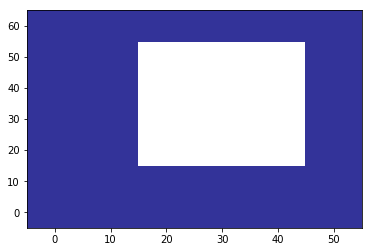

In [60]:
plt.pcolor(xc,yc,mmask,cmap=plt.cm.terrain)